<a href="https://colab.research.google.com/github/MudassirABBASSi/Computer-Vision/blob/main/Paper_Pattern_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install opencv-python
!pip install numpy
!pip install poppler-utils
!pip install pdf2image opencv-python-headless numpy pytesseract imutils
!apt-get install poppler-utils
!apt-get install tesseract-ocr



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.

In [28]:
import cv2
import numpy as np
import pytesseract
import imutils
from google.colab.patches import cv2_imshow  # For Colab image display


Saved aligned_debug.jpg, bubbles_debug.jpg, text_debug.jpg

=== Extracted Text Fields ===
month: 
week: 
class: 
section: 
student_serial: 

=== Bubble Answers ===
B1: EMPTY
B2: EMPTY
B3: EMPTY
B4: EMPTY

Aligned Image:


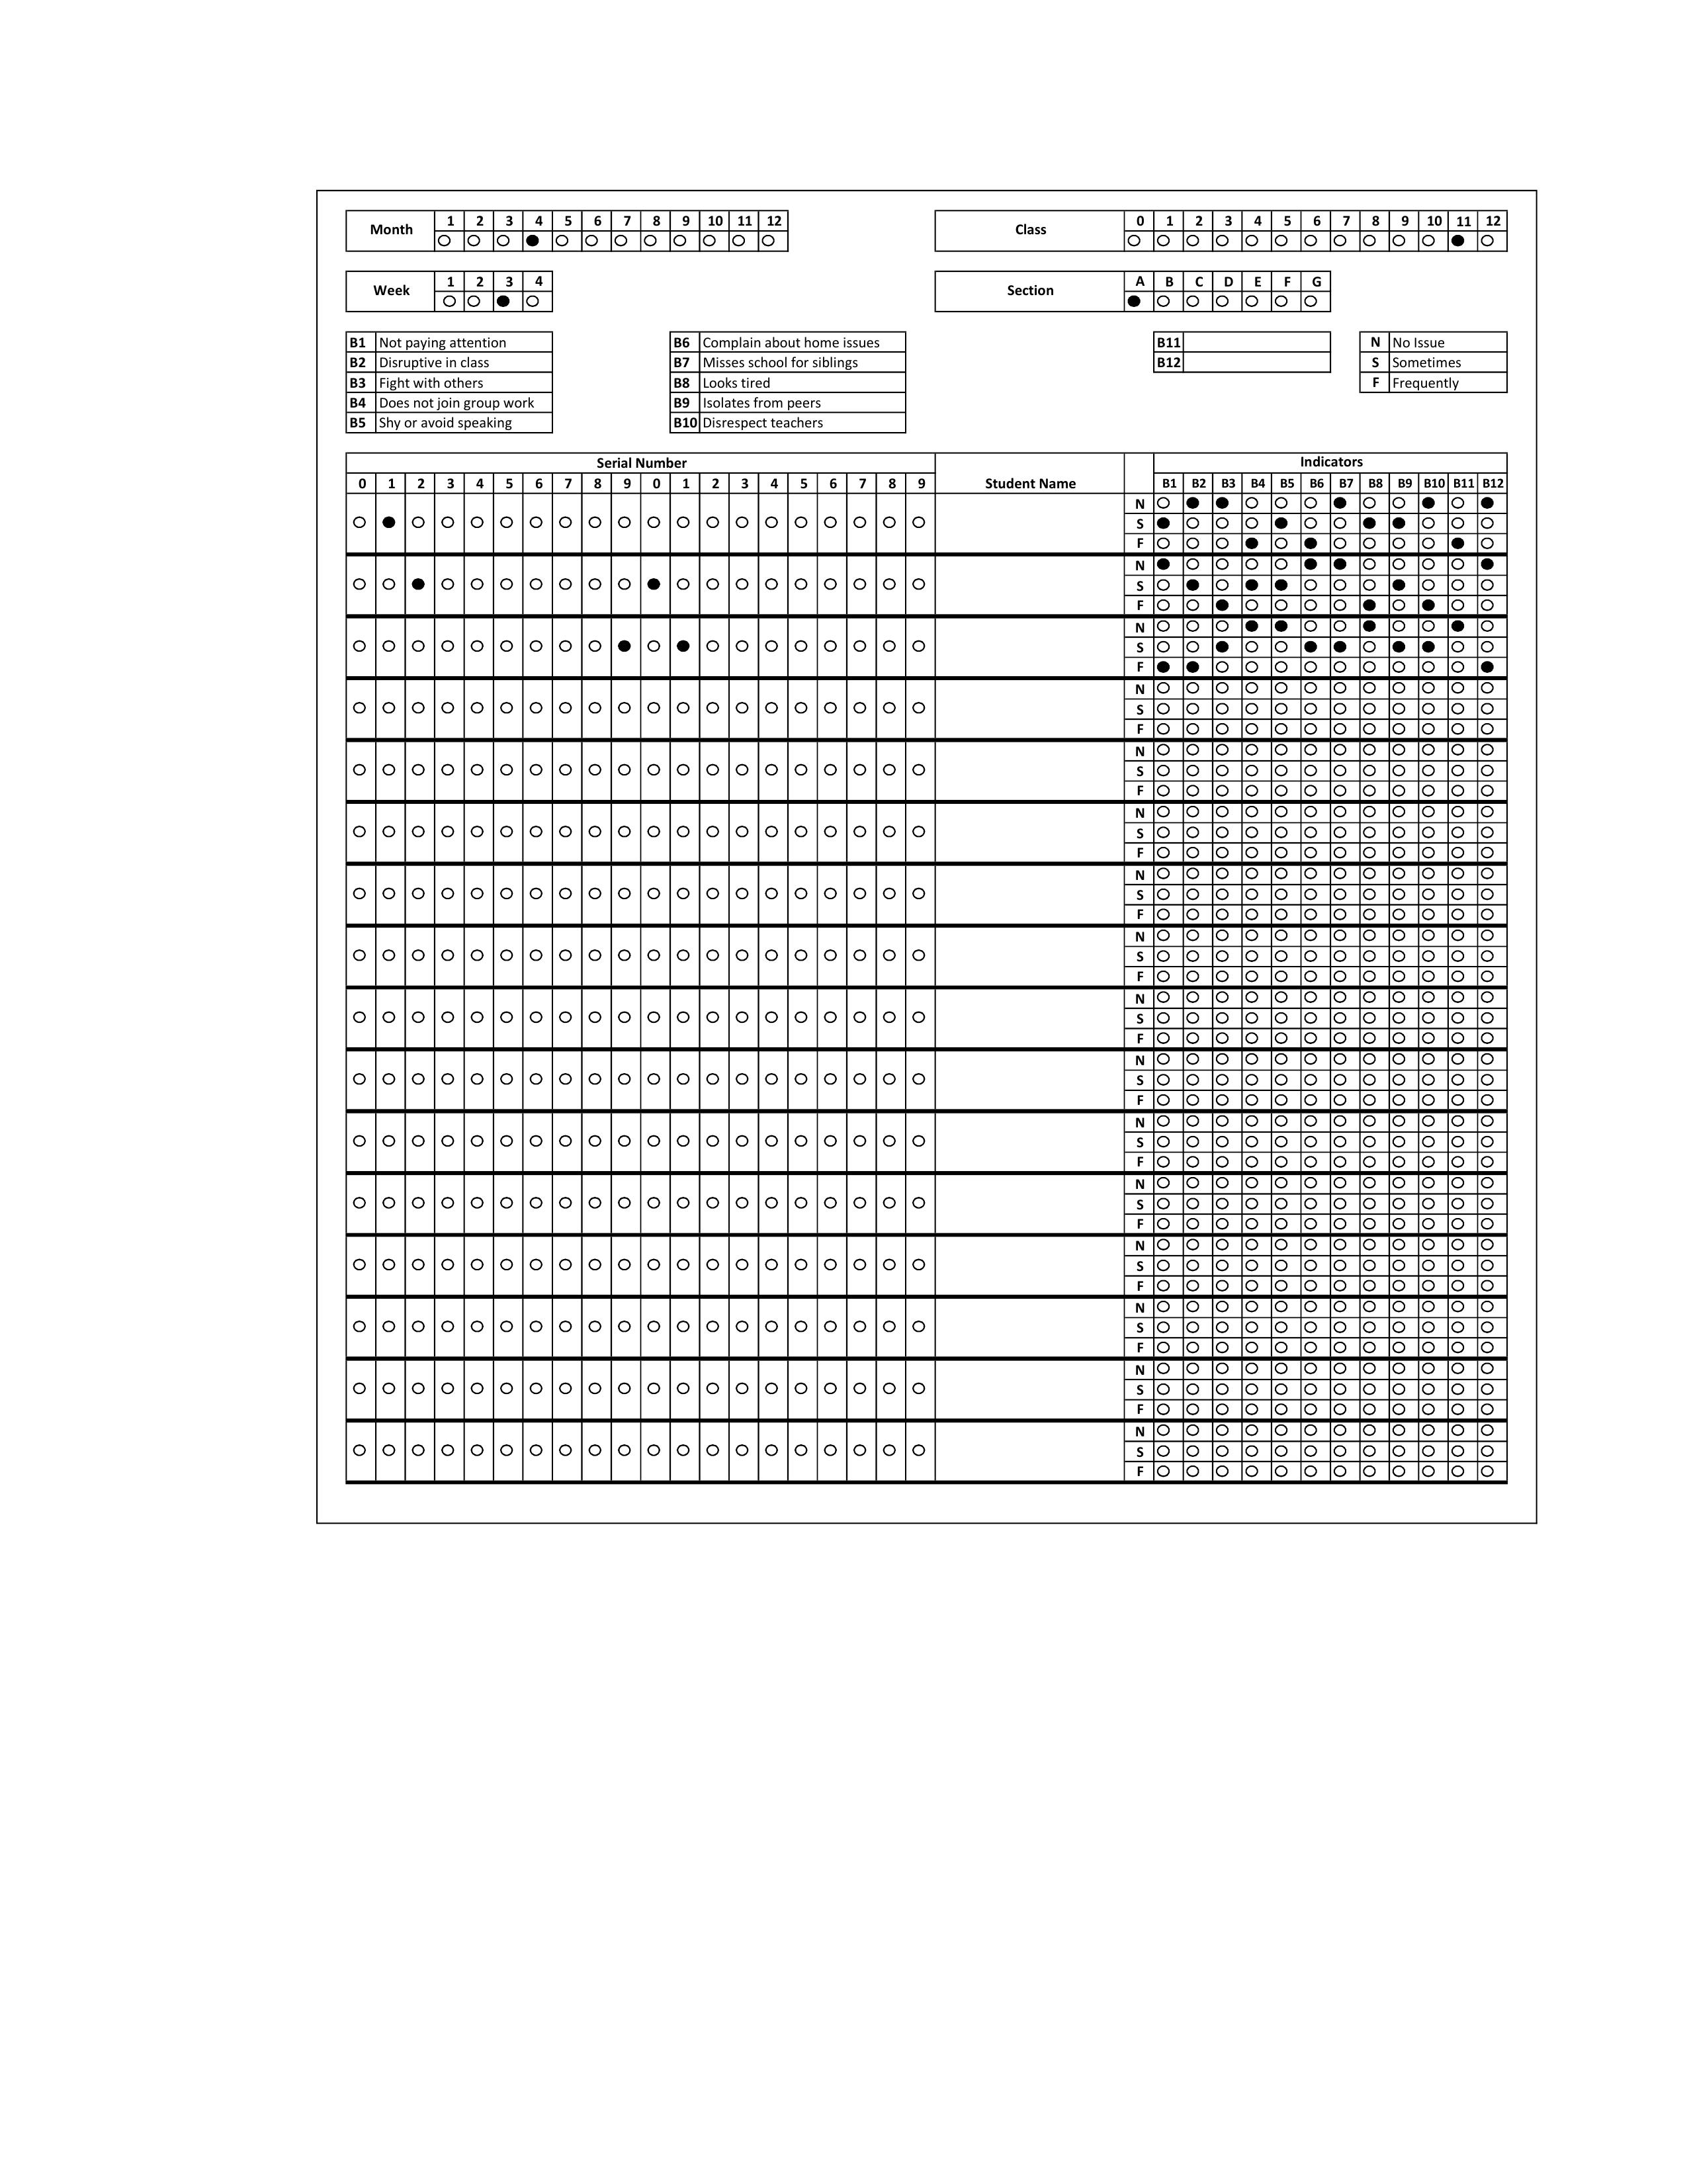

Bubbles Threshold (Inverted):


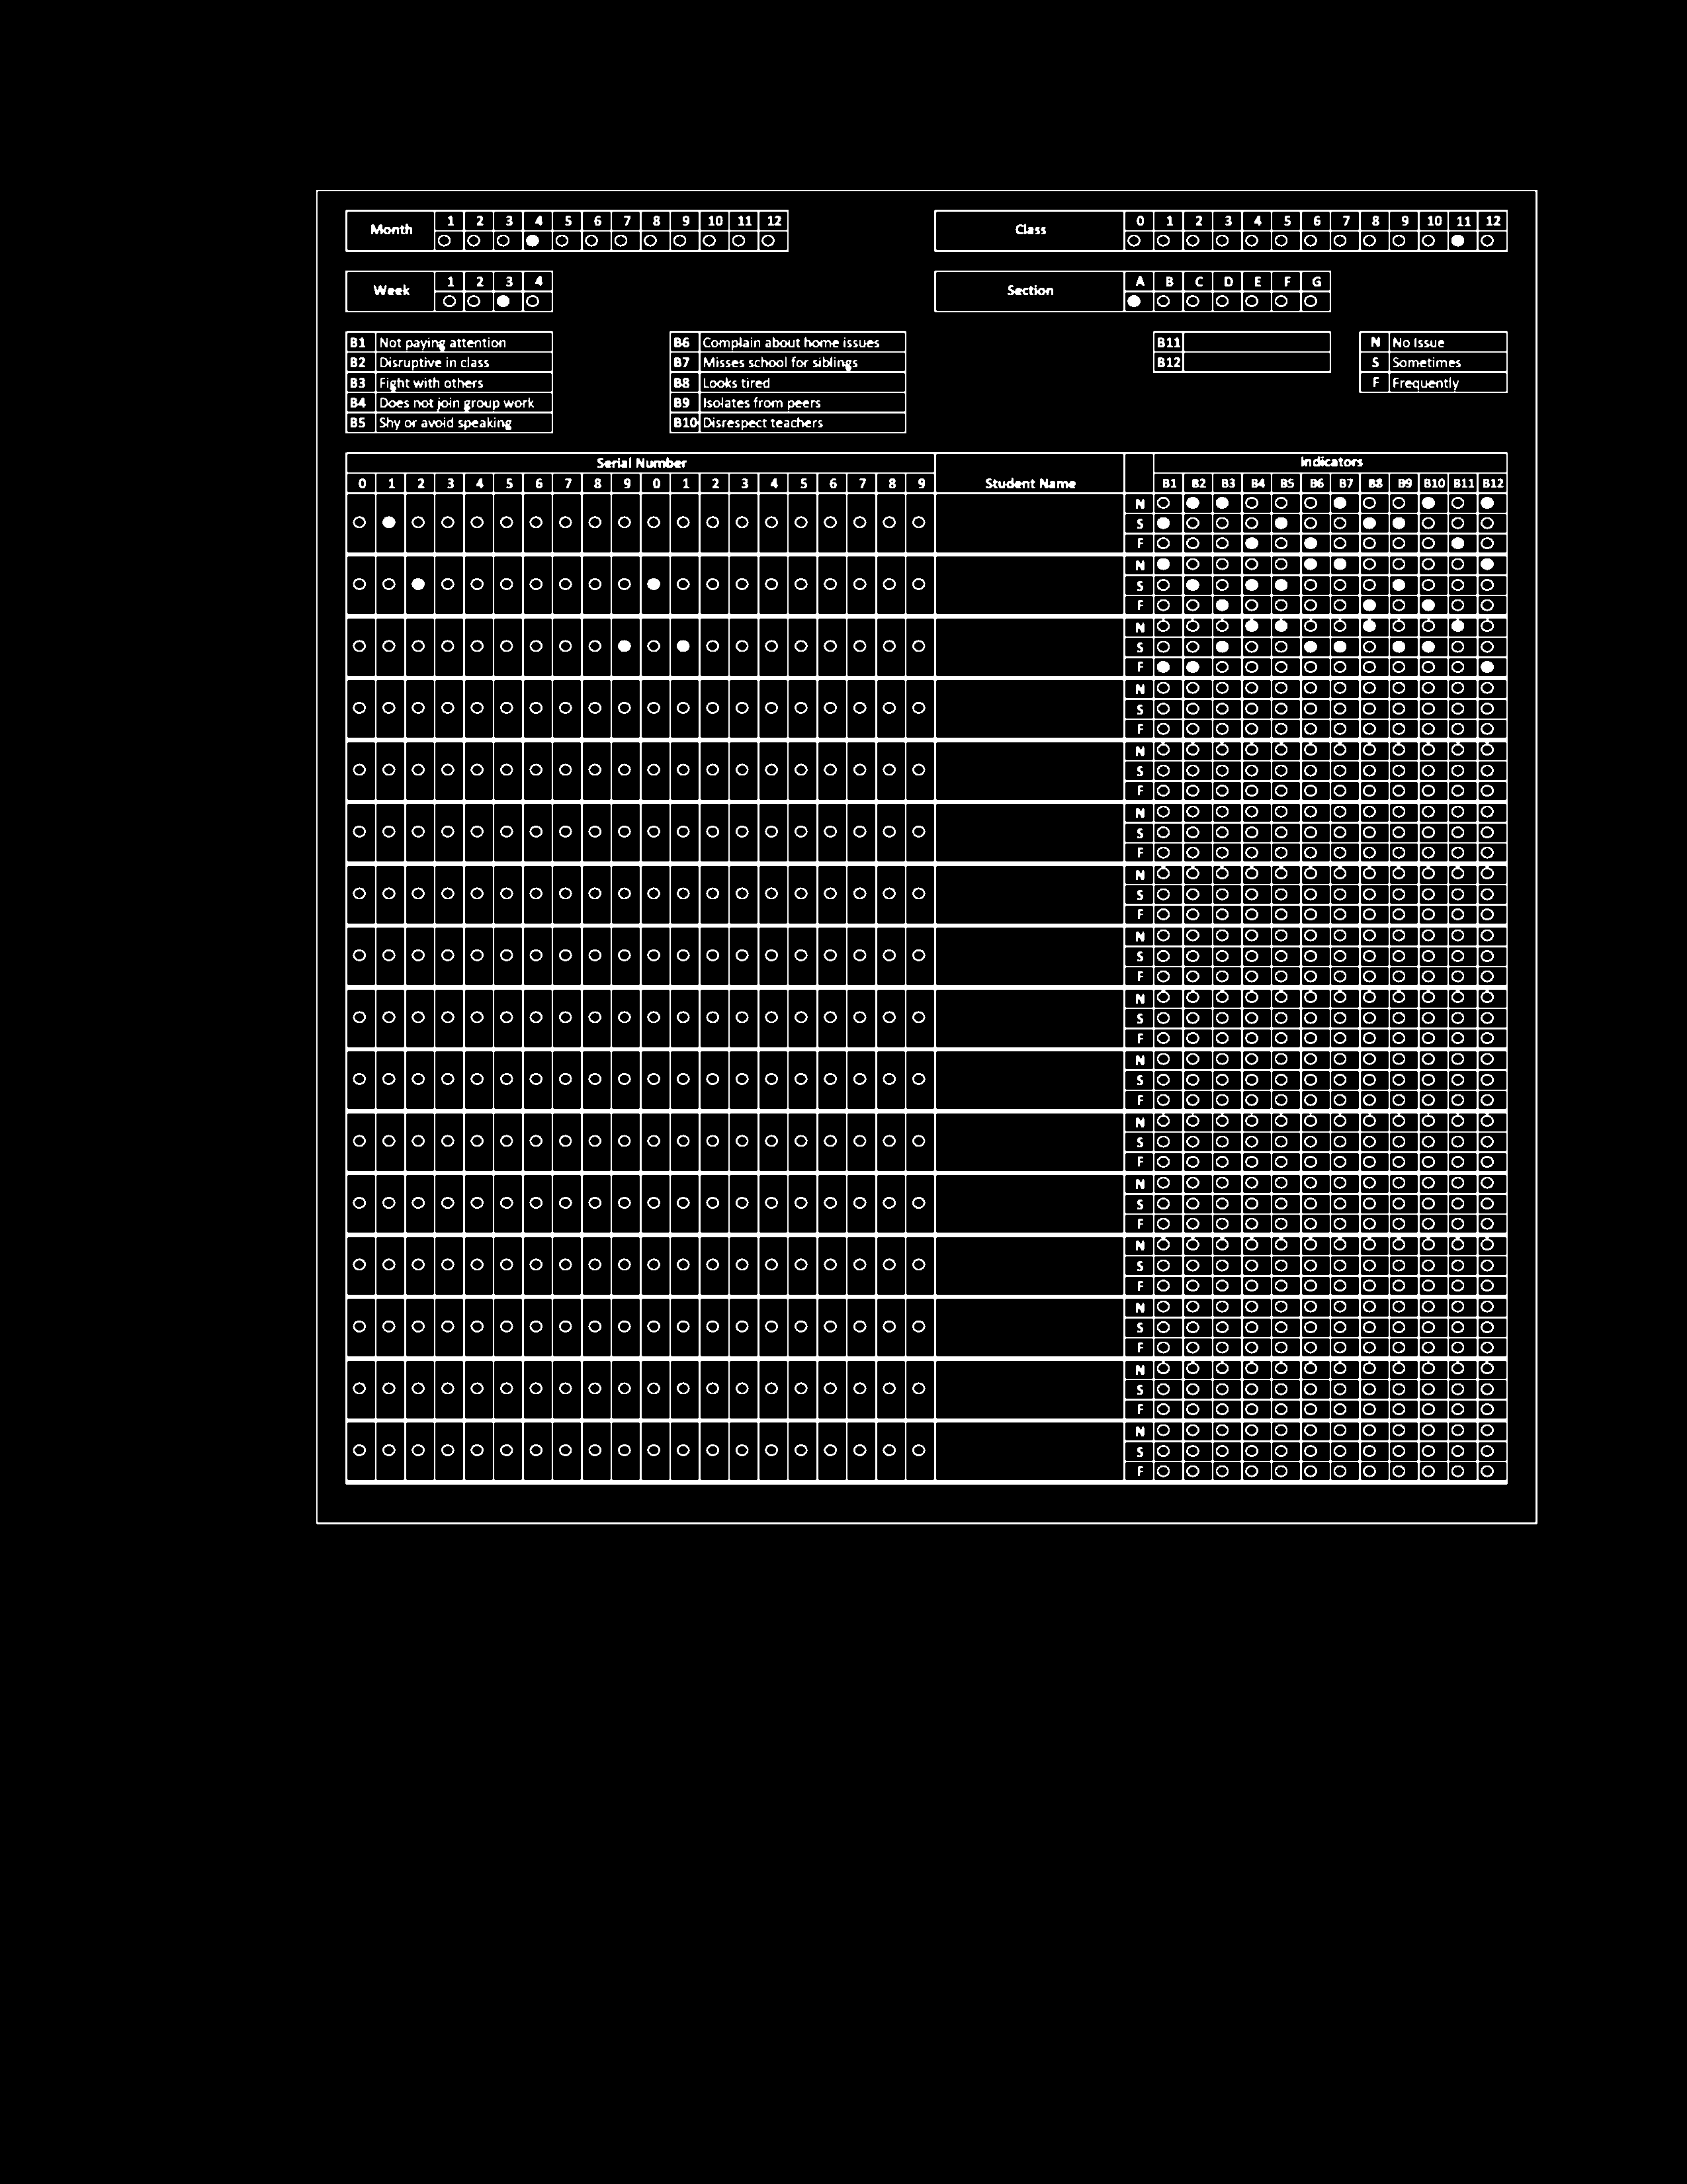

Text Threshold (Normal):


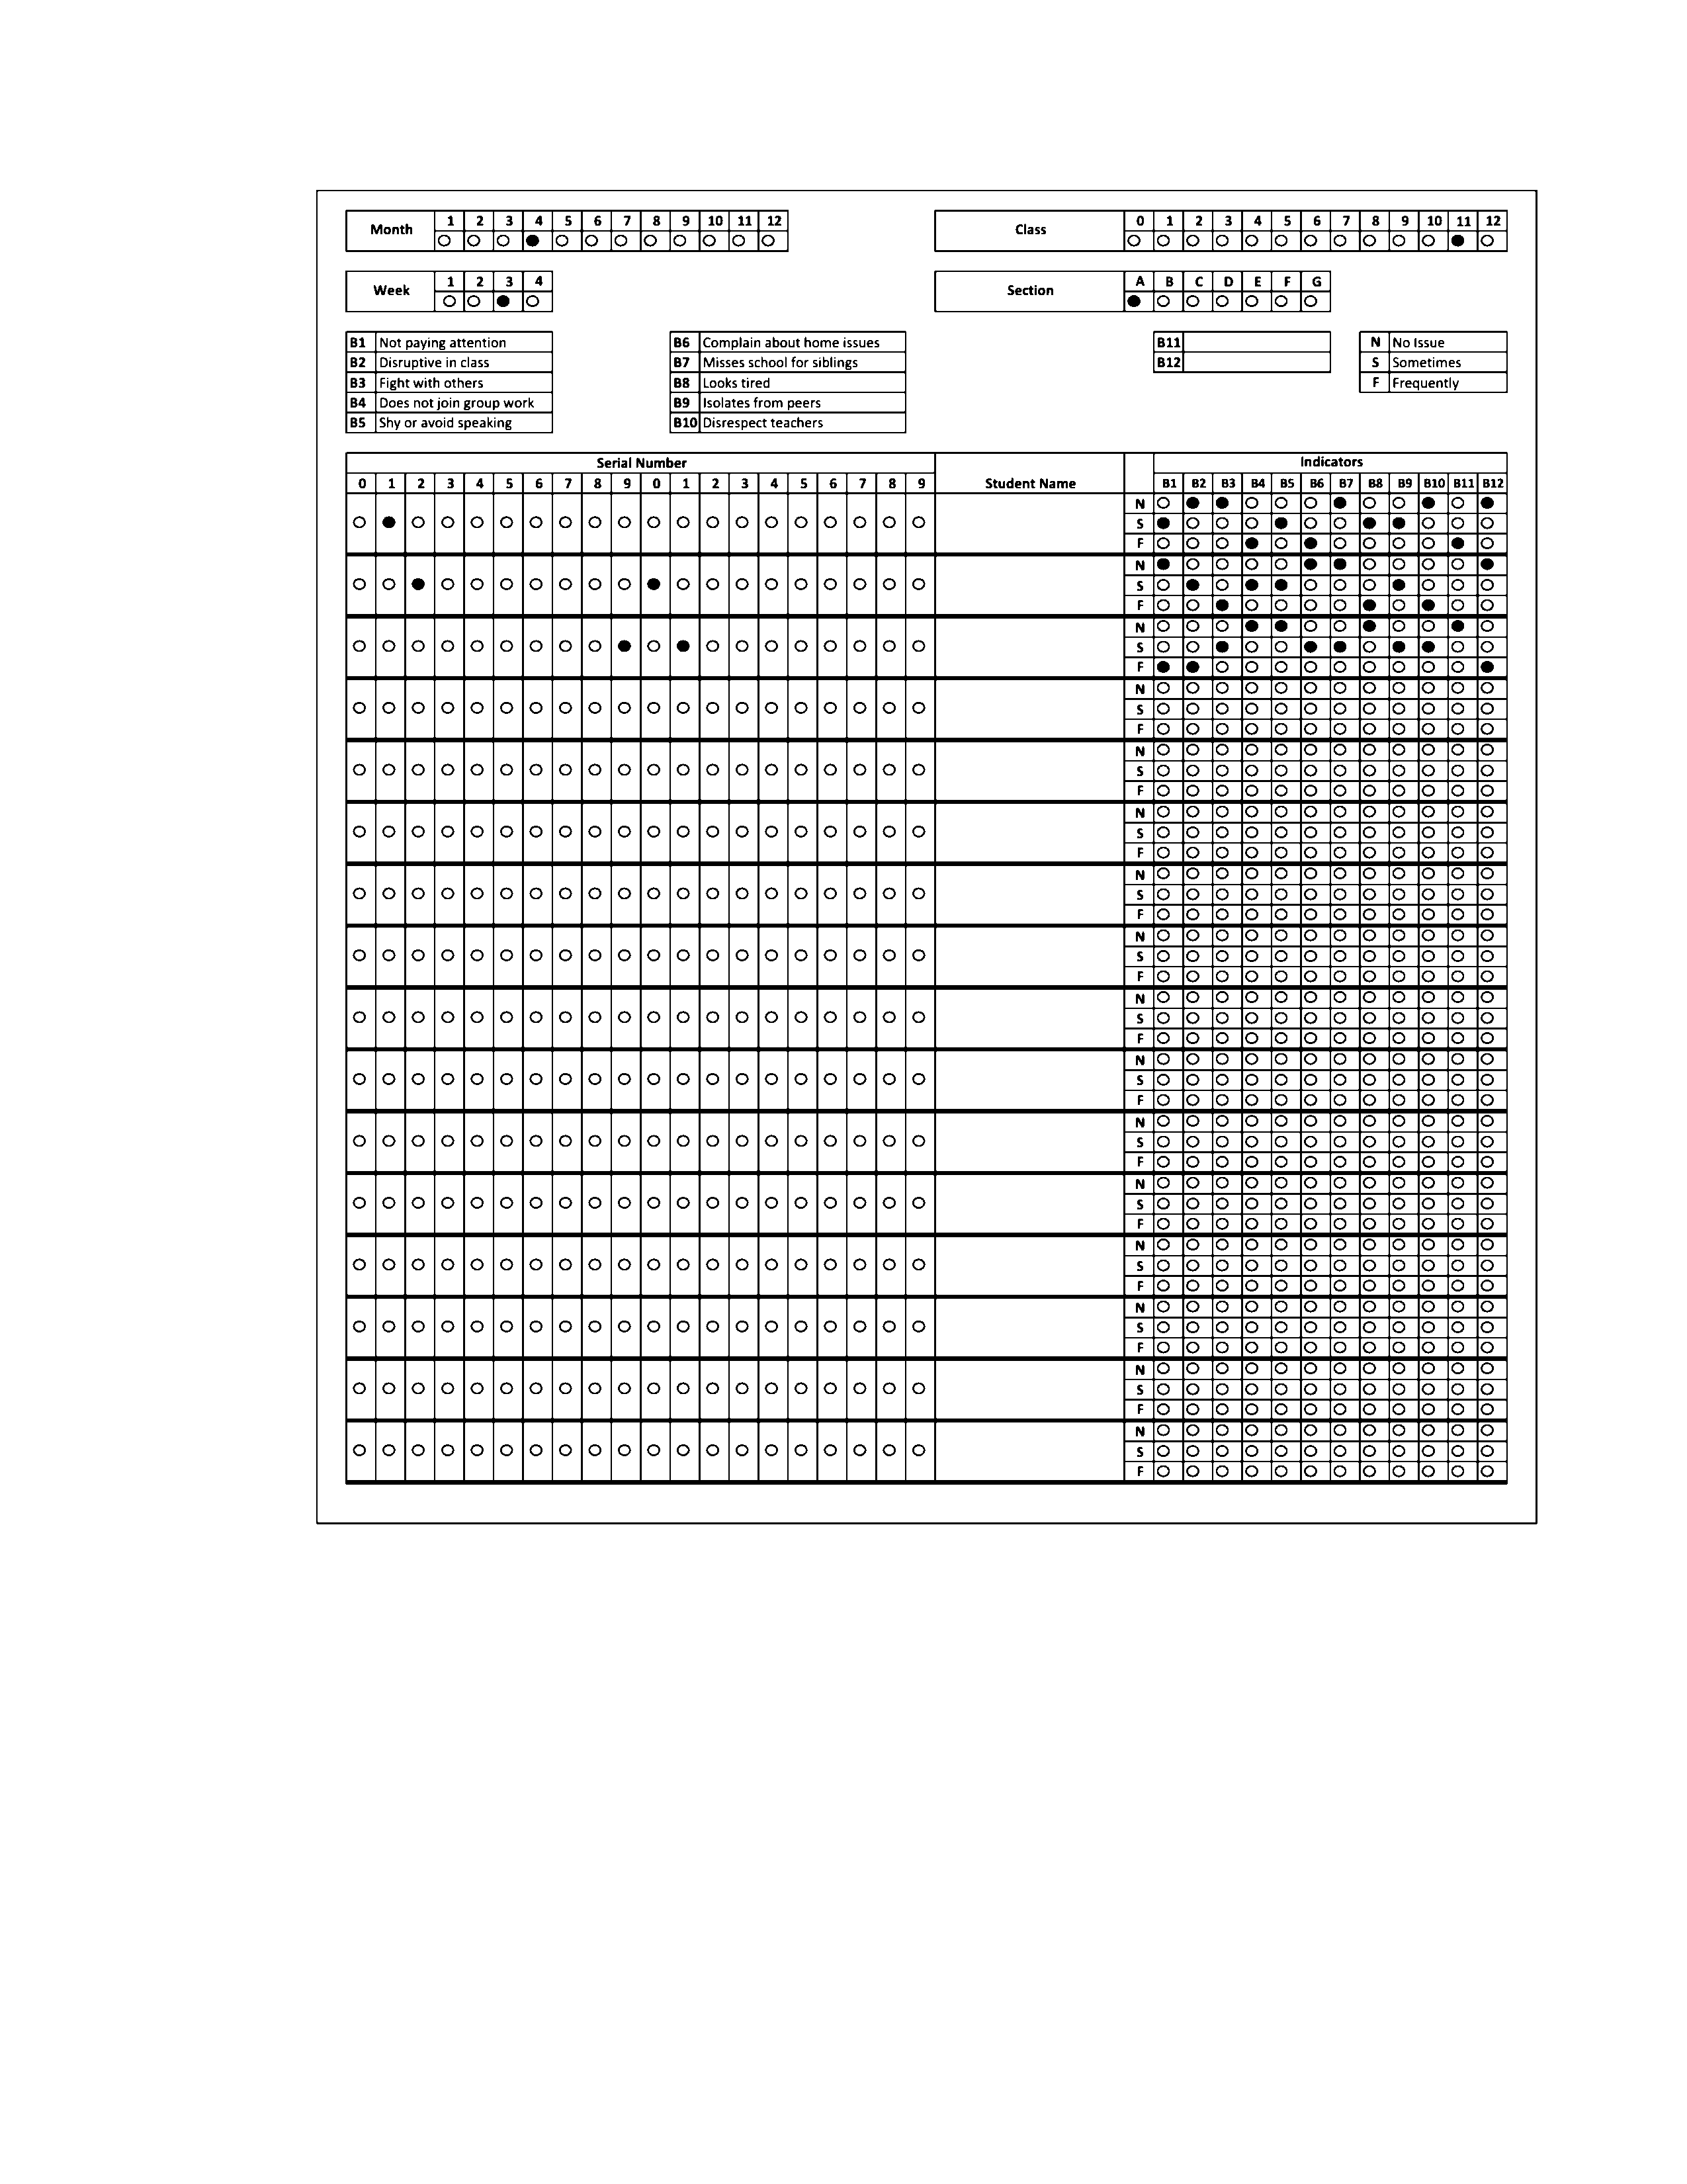

In [32]:
import cv2
import numpy as np
import pytesseract
import imutils
import os
from pdf2image import convert_from_path

# If running in Colab, import cv2_imshow
try:
    from google.colab.patches import cv2_imshow
    use_colab_imshow = True
except ImportError:
    use_colab_imshow = False

###############################################################################
# (Optional) PDF to Image Conversion
###############################################################################
def pdf_to_jpg(pdf_path, output_folder=".", dpi=300, poppler_path=None):
    """
    Converts a PDF to one or more JPEG images.
    Returns a list of image file paths.
    """
    pages = convert_from_path(pdf_path, dpi=dpi, poppler_path=poppler_path)
    image_paths = []
    for i, page in enumerate(pages):
        image_path = os.path.join(output_folder, f"page_{i+1}.jpg")
        page.save(image_path, "JPEG")
        image_paths.append(image_path)
    return image_paths

###############################################################################
# 1) Deskew Image (Rotation Correction)
###############################################################################
def deskew_image(image):
    """
    Attempt to deskew an image by detecting text angle.
    For heavier distortions, consider a perspective transform.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_inv = cv2.bitwise_not(gray)
    # Threshold to isolate text
    thresh = cv2.threshold(gray_inv, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

###############################################################################
# 2) Preprocessing for Bubbles (Inverted Threshold)
###############################################################################
def preprocess_for_bubbles(image):
    """
    Convert to grayscale, blur, then apply Otsu threshold in INV mode
    so dark filled circles become white.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    # Invert the threshold so that dark fills become white
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Optional morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    return thresh

###############################################################################
# 3) Preprocessing for Text (Normal Threshold)
###############################################################################
def preprocess_for_text(image):
    """
    Convert to grayscale, blur, then apply Otsu threshold in normal mode
    so text is black on white.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

###############################################################################
# 4) Bubble Fill Check
###############################################################################
def is_bubble_filled(thresh_image, x, y, w, h, fill_ratio_threshold=0.5):
    """
    Returns True if the ROI at (x, y, w, h) in the thresholded image
    is considered "filled" based on the fill ratio.
    """
    roi = thresh_image[y:y+h, x:x+w]
    white_pixels = cv2.countNonZero(roi)
    total_pixels = w * h
    fill_ratio = white_pixels / float(total_pixels)
    return fill_ratio > fill_ratio_threshold

###############################################################################
# 5) Main OMR Logic
###############################################################################
def main_omr(image_path):
    # 1. Load and deskew
    original = cv2.imread(image_path)
    if original is None:
        print("Error: Image not loaded. Check the file path.")
        return

    aligned = deskew_image(original)

    # 2. Separate preprocessing:
    #    a) For bubble detection (inverted threshold)
    thresh_bubbles = preprocess_for_bubbles(aligned)
    #    b) For text OCR (normal threshold)
    thresh_text = preprocess_for_text(aligned)

    # Save debug images
    cv2.imwrite("aligned_debug.jpg", aligned)
    cv2.imwrite("bubbles_debug.jpg", thresh_bubbles)
    cv2.imwrite("text_debug.jpg", thresh_text)
    print("Saved aligned_debug.jpg, bubbles_debug.jpg, text_debug.jpg")

    # -------------------------------------------------------------------------
    # Example ROI Definitions (Adjust These to Your Form)
    # -------------------------------------------------------------------------
    # Text Fields (x, y, w, h) - from top-left corner
    text_roi_definitions = {
        "month":          (300,  50, 100, 40),
        "week":           (420,  50, 100, 40),
        "class":          (540,  50, 100, 40),
        "section":        (660,  50, 100, 40),
        "student_serial": (780,  50, 200, 40),
    }

    # Bubble Fields (label, x, y, w, h)
    bubble_rois = [
        ("B1",  50,  200,  20, 20),
        ("B2",  80,  200,  20, 20),
        ("B3", 110,  200,  20, 20),
        ("B4", 140,  200,  20, 20),
        # ...
    ]

    # 3. Extract Text from thresh_text
    extracted_text = {}
    for field_name, (x, y, w, h) in text_roi_definitions.items():
        roi = thresh_text[y:y+h, x:x+w]  # black text on white
        text_val = pytesseract.image_to_string(roi, config="--psm 6").strip()
        extracted_text[field_name] = text_val

    # 4. Extract Bubble Answers from thresh_bubbles
    bubble_results = {}
    for (label, x, y, w, h) in bubble_rois:
        filled = is_bubble_filled(thresh_bubbles, x, y, w, h, fill_ratio_threshold=0.5)
        bubble_results[label] = filled

    # 5. Print Results
    print("\n=== Extracted Text Fields ===")
    for k, v in extracted_text.items():
        print(f"{k}: {v}")

    print("\n=== Bubble Answers ===")
    for label, filled in bubble_results.items():
        status = "FILLED" if filled else "EMPTY"
        print(f"{label}: {status}")

    # 6. (Optional) Visual Debug in Colab
    if use_colab_imshow:
        from google.colab.patches import cv2_imshow
        print("\nAligned Image:")
        cv2_imshow(aligned)
        print("Bubbles Threshold (Inverted):")
        cv2_imshow(thresh_bubbles)
        print("Text Threshold (Normal):")
        cv2_imshow(thresh_text)

###############################################################################
# Example usage
###############################################################################
if __name__ == "__main__":
    # If you have a PDF, convert it first (optional):
    # pdf_images = pdf_to_jpg("my_form.pdf", dpi=300)
    # main_omr(pdf_images[0])

    # Or directly an image:
    image_path = "/content/page_1.jpg"  # Update this to your actual image path
    main_omr(image_path)
